# Exploring Impact of TAS (Figure 2)

The BROAD Institute provides an additional metric called transcriptional activity score (TAS), which measures the impact that the drug has on the cell. This code notebook explores how the TAS score impacts the performance of the model. To do this, the DRH datasets were filtered at various TAS cutoffs and the AUCs were obtained at each TAS cutoff.

## *1. Import the DRH datasets*

In [1]:
# import data manipulation tools
import pandas as pd

In [2]:
### initialize dictionaries to store the DRH datasets
DRH_data = {}
### store a list of the cell lines used
cell_lines = ["A375", "MCF7", "PC3"]

### iterate through each cell line
for cell_line in cell_lines:
    ## store the DRH and clinical datasets in their respective dictionaries
    file_path = "./DRH_clin_data/DRH_data/" + cell_line + "_unique_ind.txt"
    DRH_data[cell_line] = pd.read_csv(file_path)

DRH_data["MCF7"].head()

,drug1,drug1 tas,drug2,drug2 tas,spearman corr,indication,known ind
0,midostaurin,0.799386,altrenogest,0.812819,0.908978,Estrus,False
1,altrenogest,0.812819,midostaurin,0.799386,0.908978,"Leukemia, Myeloid, Acute",False
2,ixazomib-citrate,0.747696,ixazomib,0.791817,0.889649,Multiple Myeloma,True
3,ixazomib,0.791817,ixazomib-citrate,0.747696,0.889649,Multiple Myeloma,True
4,carfilzomib,0.763093,ixazomib-citrate,0.747696,0.839315,Multiple Myeloma,True


## *2. Generate DRH datasets filtered using various TAS cutoff*

In [3]:
### function to select only drug-indication pairs above TAS cutoff
def gen_tas_datasets(cell_line_data):
    ## initialize a dictionary to store all the filtered datasets at each tas cutoff
    tas_data = {}
    ## iterate through each tas cutoff
    for tas_cutoff in tas_cutoffs:
        ## store only drug-indication pairs below tas cutoff in the dictionary
        drug1_above_tas = cell_line_data["drug1 tas"] > tas_cutoff
        drug2_above_tas = cell_line_data["drug2 tas"] > tas_cutoff
        tas_data[tas_cutoff] = cell_line_data.loc[drug1_above_tas & drug2_above_tas]
        
    return tas_data

In [4]:
### initialize a dictionary to store all the shared data across all cell lines
tas_data = {}

### store a list of all tas cutoffs of interest
tas_cutoffs = [0, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

### iterate through each cell line
for cell_line, cell_line_data in DRH_data.items():
    ## generate the store the tas datasets for this shared data
    tas_data[cell_line] = gen_tas_datasets(cell_line_data)
    
tas_data["MCF7"][0.5].head()

,drug1,drug1 tas,drug2,drug2 tas,spearman corr,indication,known ind
0,midostaurin,0.799386,altrenogest,0.812819,0.908978,Estrus,False
1,altrenogest,0.812819,midostaurin,0.799386,0.908978,"Leukemia, Myeloid, Acute",False
2,ixazomib-citrate,0.747696,ixazomib,0.791817,0.889649,Multiple Myeloma,True
3,ixazomib,0.791817,ixazomib-citrate,0.747696,0.889649,Multiple Myeloma,True
4,carfilzomib,0.763093,ixazomib-citrate,0.747696,0.839315,Multiple Myeloma,True


## *3. Get the number of compounds at each TAS cutoff and AUCs*

In [5]:
# import package to calculate the AUC
from sklearn.metrics import roc_auc_score

In [6]:
### function to obtain the relavent information at a TAS cutoff
def gen_tas_info(cell_line_data):
    ## initialize a dataframe to store the relavent information
    cell_line_info = pd.DataFrame(columns=["TAS cutoff", "# of drugs", "AUC"])
    ## iterate through each TAS dataset
    for tas_cutoff, tas_data in cell_line_data.items():
        # get the AUC using only spearman correlation
        pred = tas_data["spearman corr"]
        actual = tas_data["known ind"]
        auc = roc_auc_score(actual, pred)
        # add the information about that TAS dataset to the dataframe
        tas_info = {"TAS cutoff": tas_cutoff,
                    "# of drugs": tas_data["drug1"].nunique(),
                    "AUC": auc}
        cell_line_info = cell_line_info.append(tas_info, ignore_index=True)
    
    ## sort rows from lowest to highest TAS cutoff
    cell_line_info.sort_values("TAS cutoff", inplace=True)
    ## add another column with the % of all drugs available to predict for
    cell_line_info["% of all drugs"] = cell_line_info["# of drugs"]/cell_line_info.iloc[0, 1]
    
    return cell_line_info

In [7]:
### initialize a dictionary to store the information across 
tas_info = {}
### iterate through each TAS dataset
for cell_line, cell_line_data in tas_data.items():
    ## generate and store the relevant information about that dataset in dictionary
    tas_info[cell_line] = gen_tas_info(cell_line_data)

tas_info["MCF7"]

,TAS cutoff,# of drugs,AUC,% of all drugs
0,0.00,799.0,0.692473,1.000000
2,0.20,469.0,0.719759,0.586984
1,0.25,322.0,0.740437,0.403004
4,0.30,237.0,0.766510,0.296621
6,0.35,169.0,0.794176,0.211514
3,0.40,140.0,0.806166,0.175219
5,0.45,109.0,0.812415,0.136421
7,0.50,81.0,0.800318,0.101377


## *4. Compare the spearman correlations for data filtered for each TAS cutoff*

In [8]:
# import the data visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# set theme of figures
sns.set_style("whitegrid")

# set the font sizes of plots
plt.rcParams["axes.titlesize"] = 17 # title 
plt.rcParams["axes.labelsize"] = 15 # X and y axis labels
plt.rcParams["xtick.labelsize"] = 15  # X tick labels
plt.rcParams["ytick.labelsize"] = 15  # Y tick labels
plt.rcParams["legend.fontsize"] = 15 # legend

In [10]:
### function to generate plot comparing the spearman correlations across TAS cutoffs
def compare_corrs(cell_line, ax):
    ## define offset between violin plots
    offset = 0.4
    ## iterate through each TAS dataset
    for i, tas_cutoff in enumerate(tas_cutoffs):
        ## get the dataset at that tas cutoff
        data = tas_data[cell_line][tas_cutoff]
        ## separate the data into two dataframes based on whether or not they treat the same indication
        diff_ind = data[~data["known ind"]]["spearman corr"]
        same_ind = data[data["known ind"]]["spearman corr"]
        ## generate the violin plots
        diff_ind_plt = ax.violinplot(diff_ind, positions=[2*i-offset], showmeans=True)
        same_ind_plt = ax.violinplot(same_ind, positions=[2*i+offset], showmeans=True)

        ## set color of violin plots
        color1 = sns.color_palette("muted")[0]
        color2 = "#73bc83"
        for plt1 in diff_ind_plt["bodies"]:
            plt1.set_facecolor(color1)
        for plt2 in same_ind_plt["bodies"]:
            plt2.set_facecolor(color2)

        parts = ["cbars", "cmins", "cmeans", "cmaxes"]
        for pt in parts:
            diff_ind_plt[pt].set_color(color1)
            same_ind_plt[pt].set_color(color2)

    ## add labels
    ax.set_title("Spearman Correlations Across TAS Cutoffs (" + cell_line + " cell line)")
    ax.set_ylabel("Spearman Correlation")
    ax.set_xlabel("TAS cutoff")
    ax.set_xticks([2*i for i in range(len(tas_cutoffs))])
    ax.set_xticklabels(tas_cutoffs) 
    
    ## add legend
    diff_ind_patch = plt.Line2D([0], [0], color=color1, lw=4, label="Do Not Share Indication")
    same_ind_patch = plt.Line2D([0], [0], color=color2, lw=4, label="Share Indication")
    ax.legend(handles=[diff_ind_patch, same_ind_patch], loc="lower right")

In [11]:
### function to generate plot comparing number of drugs and AUC across TAS cutoffs
def compare_aucs(cell_line, ax):
    ## get the dataset for that cell line
    data = tas_info[cell_line]
    ## add a line plot showing the AUCs across TAS cutoffs
    ax.plot(data["TAS cutoff"], data["AUC"], marker="o", label="AUC")
    ax.plot(data["TAS cutoff"], data["% of all drugs"], marker="o", label="% of all drugs available")
    
    ## add labels
    ax.set_title("Number of Drugs and AUCs Across TAS Cutoffs (" + cell_line + " cell line)")
    ax.set_xlabel("TAS cutoff")
    ax.legend()

In [12]:
### function to generate figures comparing the spearman correlations and AUCs at each TAS cutoff for one cell line
def compare_tas(cell_line):
    ## create an empty figure with two plot side by side
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ## generate the left plot comparing spearman correlations across TAS cutffs
    compare_corrs(cell_line, ax1)
    ## generate right plot comparing the number of drugs that model could predict for and AUC
    compare_aucs(cell_line, ax2)
    ## show plot
    plt.show()

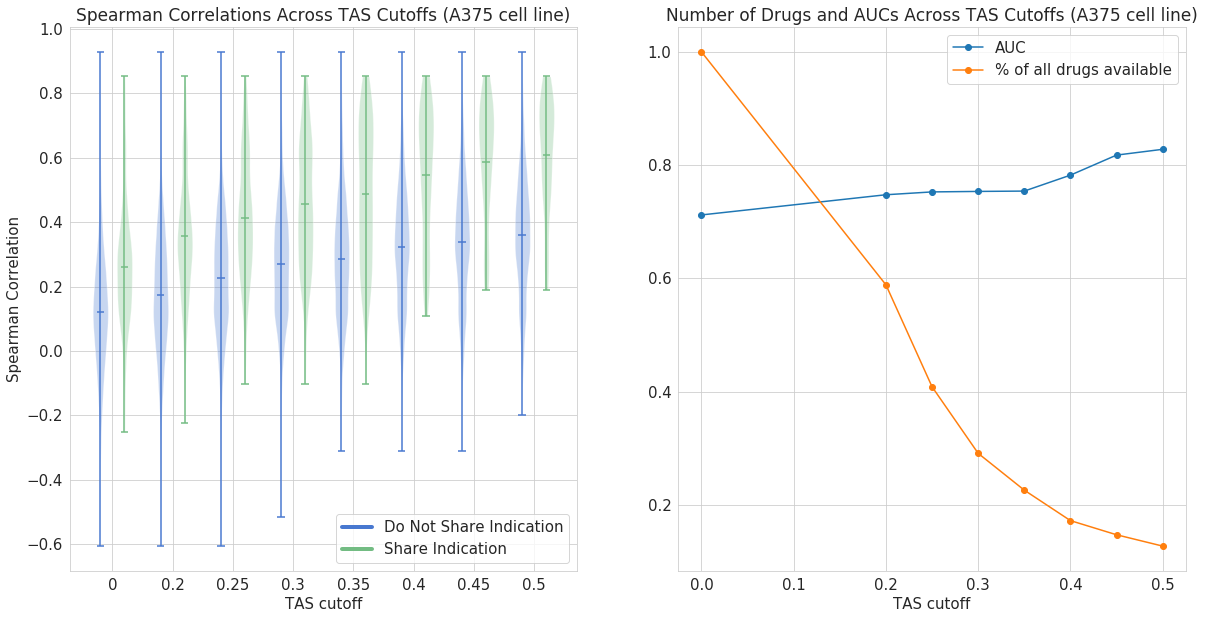

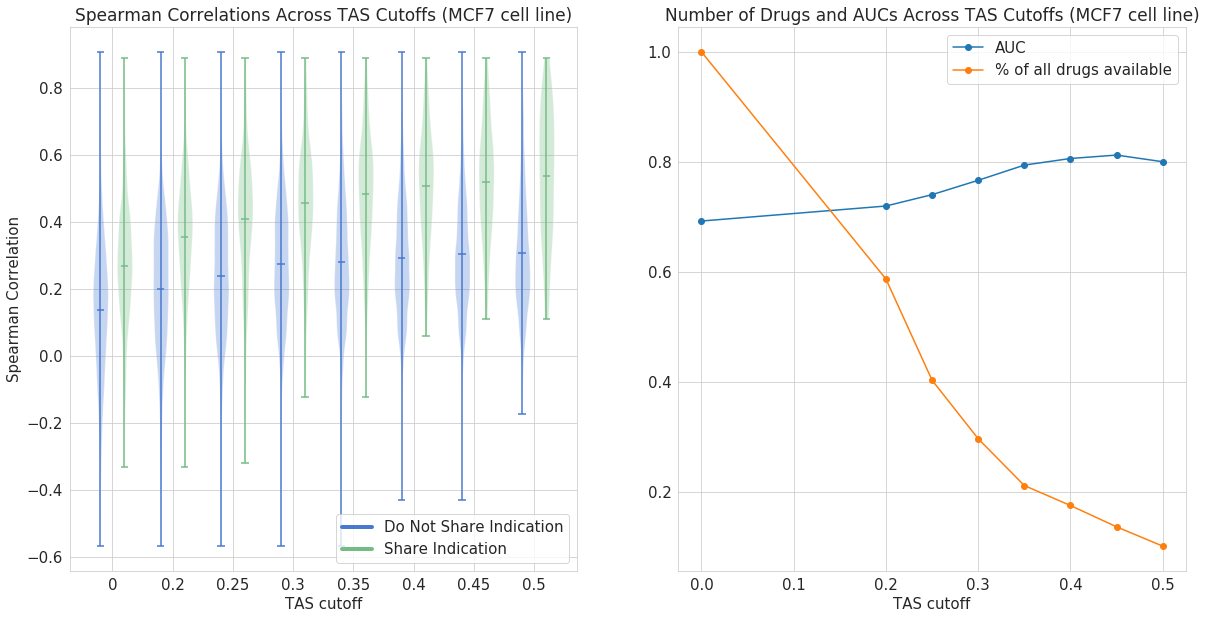

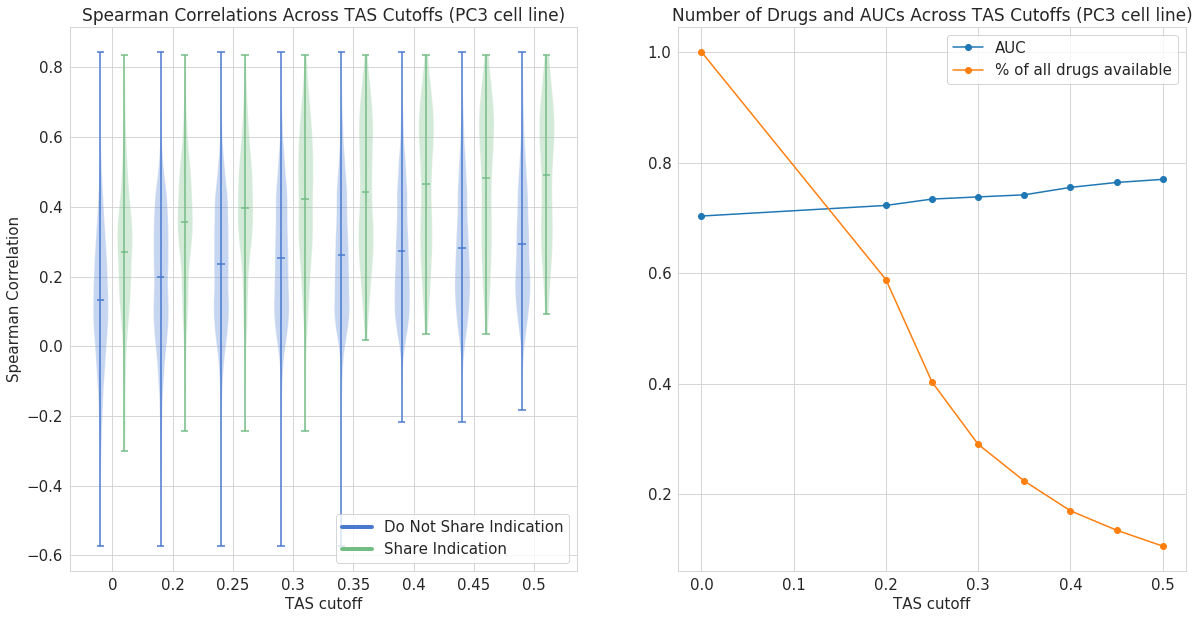

In [13]:
### iterate through each cell line
for cell_line in cell_lines:
    ## generate figure comparing spearman correlation based models across various TAS cutoffs for cell line
    compare_tas(cell_line)